In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.analysis import *
from src.modeling import *
from src.data import FTRC_Data

import json
import warnings
warnings.filterwarnings('ignore')
# Import battery failure data bank
data_train = FTRC_Data()
# Remove all SOCs except 100%
data_train.df = data_train.df[data_train.df["Pre-Test-State-of-Charge-%"] == 100]
# Remove non-commercial cells, 'test' cells, and cells with less than 10 measurements from the data_train set
cells_to_remove = [
    'Soteria 18650 (AL)',
    'Soteria 18650 (ALCU)',
    'Soteria 18650 (CU)',
    'Soteria 18650 (DW)',
    'Soteria 18650 (ALDW)',
    'Soteria 18650 (ALCUDW)',
    'Soteria 18650 (Control)',
    'Saft D-Cell-VES16',
    'MOLiCEL 18650-J',
    'MOLiCEL 18650-M35A',
    'MOLiCEL 18650-P28A',
    'MOLiCEL 18650-Test Cell',
    'MOLiCEL 18650-Test Cell (DW-Gold)',
    'MOLiCEL 18650-Test Cell (DW-Silver)',
    'LG 18650-HG2',
    'LG 18650-M36',
    'LG 18650-Test Cell (NBV-220)',
    'LG 18650-Test Cell (NBV-250)',
    'Panasonic 18650-BE',
    'Samsung 18650-26J',
    'Samsung 18650-30Q',
    'Sony 18650-VTC6',
    ]
for cell in cells_to_remove:
    data_train.remove(cell)

# Defining features to keep
features_metadata = [
    'Cell-Description',
    'Manufacturer',
    'Geometry',
    'Cell-Capacity-Ah',
    'Trigger-Mechanism',
    'Cell-Failure-Mechanism',
    'BV Actuated',
]
features_ejected_mass = [
    'Total-Mass-Ejected-g', 'Total Ejected Mass Fraction [g/g]', # overall mass loss
    'Post-Test-Mass-Unrecovered-g', 'Unrecovered Mass Fraction [g/g]', # unrecovered mass
    'Pre-Test-Cell-Mass-g', 'Post-Test-Mass-Cell-Body-g', 'Body Mass Remaining Fraction [g/g]', # body mass loss
    'Positive-Mass-Ejected-g', 'Positive Ejected Mass Fraction [g/g]', # positive end mass loss
    'Negative-Mass-Ejected-g', 'Negative Ejected Mass Fraction [g/g]', # negative end mass loss
]
# Target variables
targets = [
    'Total Heat Output [kJ/A*h]',
    'Cell Body Heat Output [kJ/A*h]',
    'Positive Heat Output [kJ/A*h]',
    'Negative Heat Output [kJ/A*h]',
]

# Lots of extra columns in the data set, only keep the defined subset for modeling
data_trimmed_train = data_train.df[features_metadata + features_ejected_mass + targets]

In [13]:
# Make a test data frame; we will do i-shot tests one cell type at a time, while using all of the 'original' data set to train.
# Import battery failure data bank
data_test = FTRC_Data()
# Remove all SOCs except 100%
data_test.df = data_test.df[data_test.df["Pre-Test-State-of-Charge-%"] == 100]
# Test some of the removed cells, except 'test' cells, which have weird modifications, and cells that have basically no data
cells_to_test = [
    'Soteria 18650 (Control)',
    'Saft D-Cell-VES16',
    'MOLiCEL 18650-M35A',
    'MOLiCEL 18650-P28A',
    'LG 18650-M36',
    'LG 18650-Test Cell (NBV-220)',
    'LG 18650-Test Cell (NBV-250)',
    'Samsung 18650-26J',
    'Samsung 18650-30Q',
    ]
data_test.df = data_test.df[data_test.df['Cell-Description'].isin(cells_to_test)].reset_index(drop=True)
data_trimmed_test = data_test.df[features_metadata + features_ejected_mass + targets]

y_test_pred = {}
errors = {}
for cell_type in cells_to_test:
    print(cell_type)
    
    y_test_pred_cell = {}
    errors_cell = {}

    data_this_cell = pd.concat((data_trimmed_train, data_trimmed_test[data_trimmed_test['Cell-Description'] == cell_type])).reset_index(drop=True)
    max_i = data_this_cell.value_counts('Cell-Description')[cell_type]
    for iter in range(max_i):
        if iter == 0:
            y_test_pred_iter, errors_iter, mass_ejected_test_iter = zero_shot_svm(data_this_cell, cell_type_test=cell_type)
        else:
            y_test_pred_iter, errors_iter, mass_ejected_test_iter = i_shot_svm(data_this_cell, cell_type_test=cell_type, i=iter, max_sample_sets=100)
        y_test_pred_cell[iter]       = y_test_pred_iter
        errors_cell[iter]            = errors_iter
    
    y_test_pred[cell_type]       = y_test_pred_cell
    errors[cell_type]            = errors_cell

from pathlib import Path
with open(Path("results/svm_chain_othercells_y_test_pred.json"), "w") as f:
    json.dump(y_test_pred, f)
with open(Path("results/svm_chain_othercells_errors.json"), "w") as f:
    json.dump(errors, f)

y_test_pred = {}
errors = {}
for cell_type in cells_to_test:
    print(cell_type)
    
    y_test_pred_cell = {}
    errors_cell = {}

    data_this_cell = pd.concat((data_trimmed_train, data_trimmed_test[data_trimmed_test['Cell-Description'] == cell_type])).reset_index(drop=True)
    max_i = data_this_cell.value_counts('Cell-Description')[cell_type]
    for iter in range(max_i):
        if iter == 0:
            y_test_pred_iter, errors_iter, mass_ejected_test_iter = zero_shot_dummy(data_this_cell, cell_type_test=cell_type)
        else:
            y_test_pred_iter, errors_iter, mass_ejected_test_iter = i_shot_dummy(data_this_cell, cell_type_test=cell_type, i=iter, max_sample_sets=100)
        y_test_pred_cell[iter]       = y_test_pred_iter
        errors_cell[iter]            = errors_iter
    
    y_test_pred[cell_type]       = y_test_pred_cell
    errors[cell_type]            = errors_cell

from pathlib import Path
with open(Path("results/dummy_othercells_y_test_pred.json"), "w") as f:
    json.dump(y_test_pred, f)
with open(Path("results/dummy_othercells_errors.json"), "w") as f:
    json.dump(errors, f)

Soteria 18650 (Control)
Saft D-Cell-VES16
MOLiCEL 18650-M35A
MOLiCEL 18650-P28A
LG 18650-M36
LG 18650-Test Cell (NBV-220)
LG 18650-Test Cell (NBV-250)
Samsung 18650-26J
Samsung 18650-30Q
Soteria 18650 (Control)
Saft D-Cell-VES16
MOLiCEL 18650-M35A
MOLiCEL 18650-P28A
LG 18650-M36
LG 18650-Test Cell (NBV-220)
LG 18650-Test Cell (NBV-250)
Samsung 18650-26J
Samsung 18650-30Q


In [15]:
with open("results/svm_chain_othercells_errors.json", "rb") as file:
    d = json.load(file)
svm_errors = read_errors_json(d)
with open("results/svm_chain_othercells_y_test_pred.json", "rb") as file:
    d = json.load(file)
svm_y_test_pred = read_predictions_json(d)

with open("results/dummy_othercells_errors.json", "rb") as file:
    d = json.load(file)
dummy_errors = read_errors_json(d)
with open("results/dummy_othercells_y_test_pred.json", "rb") as file:
    d = json.load(file)
dummy_y_test_pred = read_predictions_json(d)

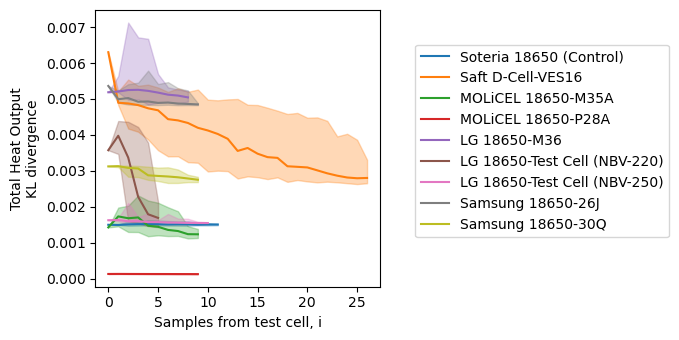

In [35]:
ax = plot_errors_singleaxis(svm_errors, metric='kl')
ax.legend(bbox_to_anchor=(1.1, 0.9))

# fig, axes = plt.subplots(3, 3, figsize=(8,8))
# axes = axes.ravel()
# plot_errors(errors, axes=axes, color='b', metric='rmse') #, y_upperlim = [4, 5, 5, 4, 7, 7, 12, 5])

In [31]:
def plot_errors__(errors, axes=None, linestyle='-', color='k', groupfunc='median', metric="rmse", label=None, y_upperlim=None):
    if groupfunc == 'mean':
        err_mean = errors.groupby(["Cell-Description","i_test"]).mean().reset_index()
    elif groupfunc == 'median':
        err_mean = errors.groupby(["Cell-Description","i_test"]).median().reset_index()
    err_lowCI_1sigma = errors.groupby(["Cell-Description","i_test"]).quantile(q=0.016).reset_index()
    err_lowCI_2sigma = errors.groupby(["Cell-Description","i_test"]).quantile(q=0.025).reset_index()
    err_highCI_1sigma = errors.groupby(["Cell-Description","i_test"]).quantile(q=0.84).reset_index()
    err_highCI_2sigma = errors.groupby(["Cell-Description","i_test"]).quantile(q=0.975).reset_index()
    cells = np.unique(errors['Cell-Description'])
    if np.all(axes==None):
        fig, axes = plt.subplots(2, 4, figsize=(16,4))
        axes = axes.ravel()
    
    ax_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n']
    metric_ = "total_" + metric
    idx = range(len(cells))
    for i, ax, cell, ax_label in zip(idx, axes, cells, ax_labels):
        err_mean_cell = err_mean.loc[err_mean["Cell-Description"] == cell, :]
        err_lowCI_1sig_cell = err_lowCI_1sigma.loc[err_lowCI_1sigma["Cell-Description"] == cell, :]
        err_highCI_1sig_cell = err_highCI_1sigma.loc[err_highCI_1sigma["Cell-Description"] == cell, :]
        err_lowCI_2sig_cell = err_lowCI_2sigma.loc[err_lowCI_2sigma["Cell-Description"] == cell, :]
        err_highCI_2sig_cell = err_highCI_2sigma.loc[err_highCI_2sigma["Cell-Description"] == cell, :]
        
        ax.plot(err_mean_cell["i_test"], err_mean_cell[metric_], linestyle, color=color, label=label)
        # ax.set_ylim(bottom=0, top=None)
        if metric != 'kl':
            if color=='b':
                ax.fill_between(err_mean_cell["i_test"], err_lowCI_1sig_cell[metric_], err_highCI_1sig_cell[metric_], alpha=0.4, color=color)
                ax.fill_between(err_mean_cell["i_test"], err_lowCI_2sig_cell[metric_], err_highCI_2sig_cell[metric_], alpha=0.2, color=color)
            else:
                ax.fill_between(err_mean_cell["i_test"], err_lowCI_1sig_cell[metric_], err_highCI_1sig_cell[metric_], alpha=0.2, color=color)
                ax.fill_between(err_mean_cell["i_test"], err_lowCI_2sig_cell[metric_], err_highCI_2sig_cell[metric_], alpha=0.1, color=color)
        ax.set_title(cell)
        if metric == 'kl':
            ax.set_yscale('log')
            ax.set_ylim([4e-4, 4])
        ax.text(0.03, 0.89, ax_label, fontsize=12, transform=ax.transAxes)
        if y_upperlim is not None:
            ax.set_ylim([0, y_upperlim[i]])

    axes[2].set_xticks([0, 5, 10])
    # axes[6].set_xticks([0, 3, 6, 9])
    # axes[7].set_xticks([0, 3, 6, 9])
    axes[8].set_xticks([0, 5, 10])
    if metric == 'kl':
        ylabel = 'Total Heat Output\nKL divergence'
    elif metric == 'rmse':
        ylabel = 'Total Heat Output\nRMSE [kJ/Ah]'

    axes[0].set_ylabel(ylabel)
    axes[3].set_ylabel(ylabel)
    axes[6].set_ylabel(ylabel)
    axes[6].set_xlabel('Samples from test cell, i')
    axes[7].set_xlabel('Samples from test cell, i')
    axes[8].set_xlabel('Samples from test cell, i')
    axes[0].legend()
    plt.tight_layout()

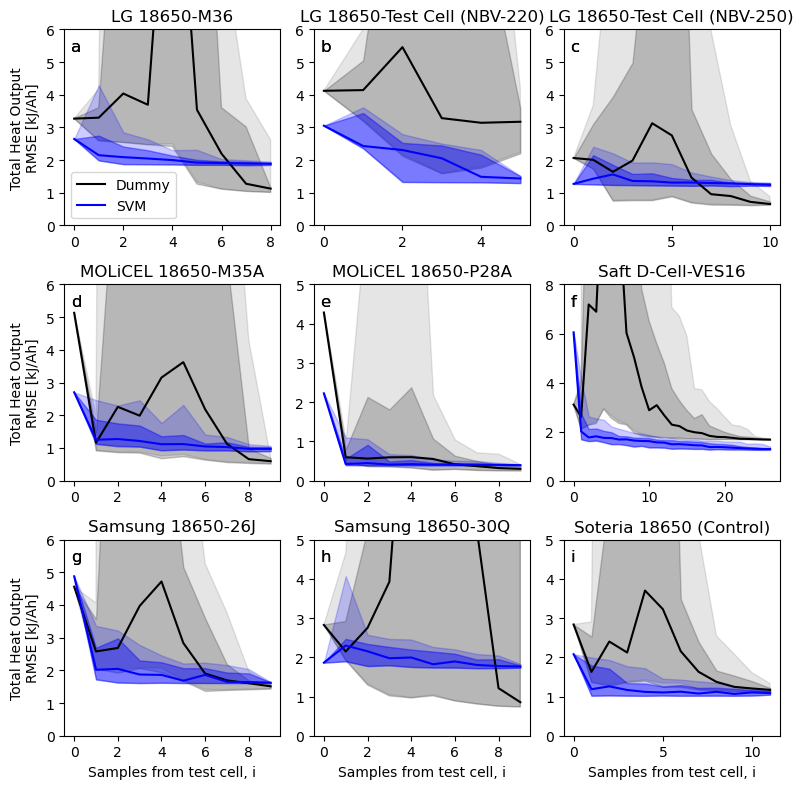

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(8,8))
axes = axes.ravel()
plot_errors__(dummy_errors, axes=axes, color='k', metric='rmse', label='Dummy')
plot_errors__(svm_errors, axes=axes, color='b', metric='rmse', label='SVM', y_upperlim = [6, 6, 6, 6, 5, 8, 6, 5, 5])